# Work Realize By TCHOKOGOUE Rayann

# Training a VAE on MNIST
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Data loading
Let's import some libraries and load the MNIST dataset.

In [44]:

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)








## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function. You can use Relu activations for every layers except for the heads that can reach negative values. Concerning the decoder head, you can use sigmoid to obtain values in [0,1].

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

In [45]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, 2)
        self.fc32 = nn.Linear(256, 2)

        # decoder part
        self.fc4 = nn.Linear(2, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)


    def encoder(self, x):
        # ...
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc31(h2)
        log_var = self.fc32(h2)
        return  mu, log_var # returns mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) # std is used only for its dimensions
        z = mu + eps*std
        return z # ... return z sample

    def decoder(self, z):
        # ...
        h1 = F.relu(self.fc4(z))
        h2 = F.relu(self.fc5(h1))
        h3 = torch.sigmoid(self.fc6(h2))
        return h3 # ...


    def forward(self, x):
        mu, log_var = self.encoder(x) # ...
        z = self.sampling(mu, log_var)
        image_rec= self.decoder(z) # ...
        return image_rec, mu, log_var


## Loss function
The total loss of the VAE is composed of two terms: a reconstruction term and the KL divergence with the Prior. The KL divergence between two gaussians is given by:

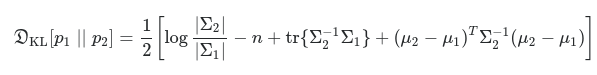

Assuming a unit gaussian as prior, we obtain a very simple equation that will help you to implement it in pytorch:

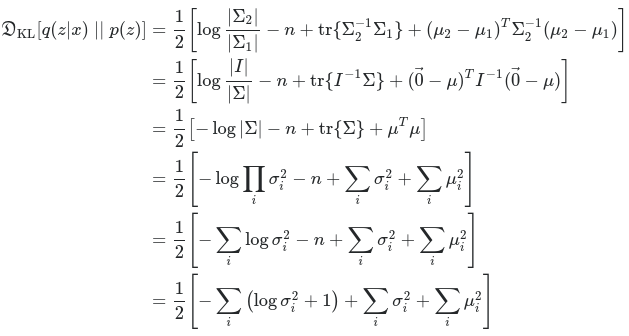

Note that, in these equations sigma denotes the standard deviation while the encoder network ouputs the log of the variance.  

In [46]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    RecLoss = F.mse_loss(recon_x, x, reduction='sum') # ...
    KLDLoss = 0.5*(-torch.sum(log_var+1) + torch.sum(torch.exp(log_var)) + torch.sum(mu**2)) # ...
    return RecLoss + KLDLoss


## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [47]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        # ...
        recon, mu, log_var = vae.forward(data.view(-1, 784))
        loss = loss_function(recon, data.view(-1,784), mu, log_var) # ...

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

## Visualization:
We provide some visualization functions:

In [48]:

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print(generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))


## Test
Complete the test function that generate new sample from latent space samples.

In [49]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae.forward(data.view(-1,784)) # ...

            # sum up batch loss
            test_loss += loss_function(recon, data.view(-1,784), mu, log_var) # ...

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    with torch.no_grad():
      z = torch.randn(64, 2).cuda()
      generated = vae.decoder(z) # ...
      plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))
      #save_image(sample.view(64, 1, 28, 28), '.sample_' + '.png')



## Main loop

Train Epoch: 1 [0/60000 (0%)]	Loss: 181.459297
Train Epoch: 1 [10000/60000 (17%)]	Loss: 50.970166
Train Epoch: 1 [20000/60000 (33%)]	Loss: 50.187480
Train Epoch: 1 [30000/60000 (50%)]	Loss: 45.894150
Train Epoch: 1 [40000/60000 (67%)]	Loss: 44.152671
Train Epoch: 1 [50000/60000 (83%)]	Loss: 41.050801
====> Epoch: 1 Average loss: 48.4976
Train Epoch: 2 [0/60000 (0%)]	Loss: 38.798906
Train Epoch: 2 [10000/60000 (17%)]	Loss: 42.880020
Train Epoch: 2 [20000/60000 (33%)]	Loss: 39.918291
Train Epoch: 2 [30000/60000 (50%)]	Loss: 40.372996
Train Epoch: 2 [40000/60000 (67%)]	Loss: 38.096855
Train Epoch: 2 [50000/60000 (83%)]	Loss: 37.519932
====> Epoch: 2 Average loss: 40.0355
Train Epoch: 3 [0/60000 (0%)]	Loss: 37.533743
Train Epoch: 3 [10000/60000 (17%)]	Loss: 39.281855
Train Epoch: 3 [20000/60000 (33%)]	Loss: 38.426348
Train Epoch: 3 [30000/60000 (50%)]	Loss: 38.204995
Train Epoch: 3 [40000/60000 (67%)]	Loss: 36.219897
Train Epoch: 3 [50000/60000 (83%)]	Loss: 39.884116
====> Epoch: 3 Average

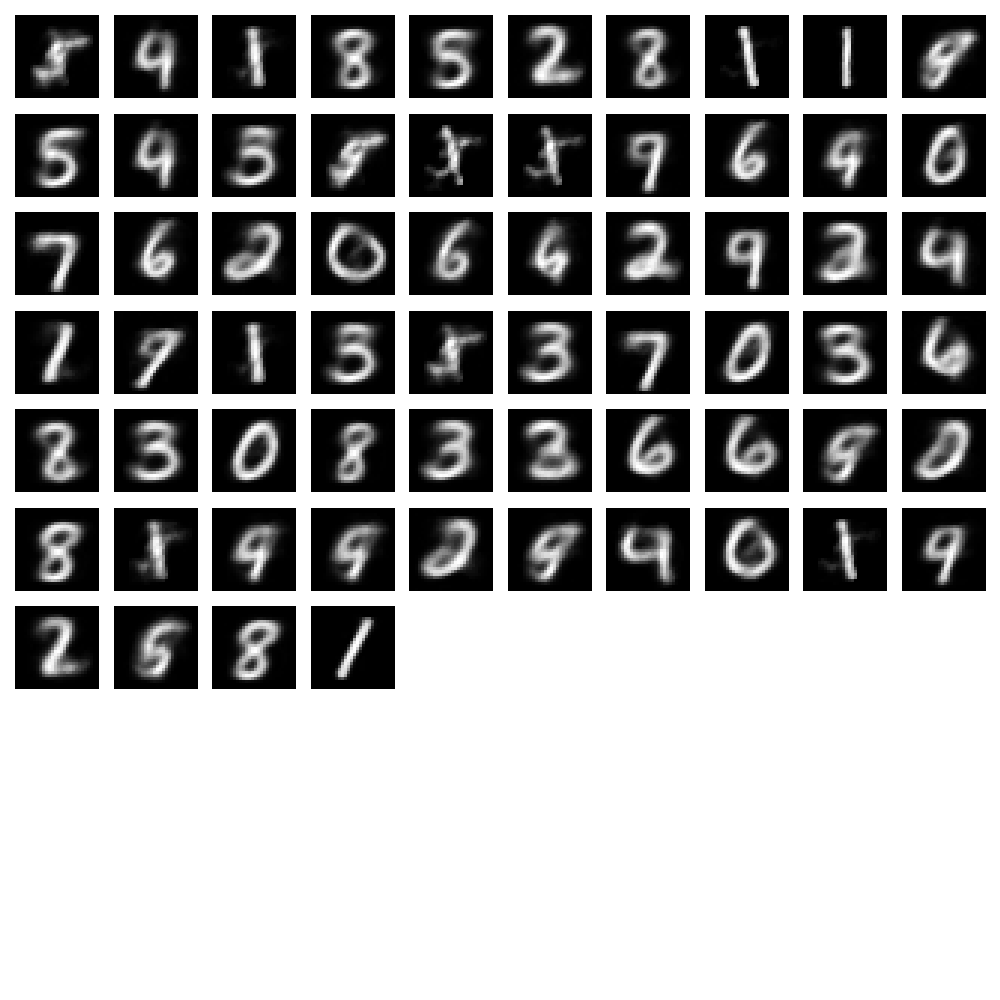

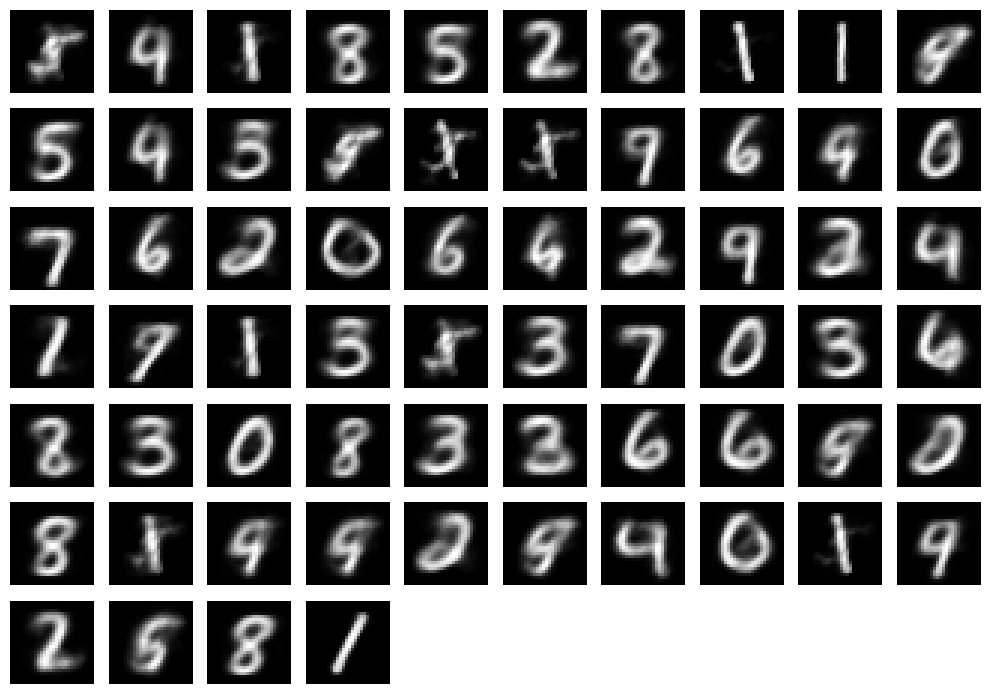

In [50]:

for epoch in range(1, 5):
    train(epoch)
test()


## Bonus 1: Interpolation
Sample two latent vectors z1 and z2 and generate the corresponding images. Then, generate 10 intermediate images by performing linear interpolation in the latent space between the z1 and z2.

(1, 1, 28, 28)


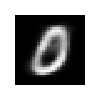

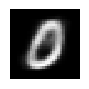

In [51]:
with torch.no_grad():
    z1 = torch.Tensor([0, 1]).cuda()
    generated = vae.decoder(z1) # ...
    plotGeneratedImages(generated.view(1, 1, 28, 28), dim=(1,1), figsize=(1,1))

(1, 1, 28, 28)


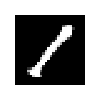

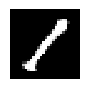

In [62]:
with torch.no_grad():
    z2 = torch.Tensor([[-6.1, 2.58]]).cuda()
    generated = vae.decoder(z2) # ...
    plotGeneratedImages(generated.view(1, 1, 28, 28), dim=(1,1), figsize=(1,1))

(10, 1, 28, 28)


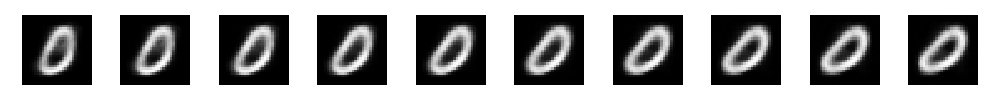

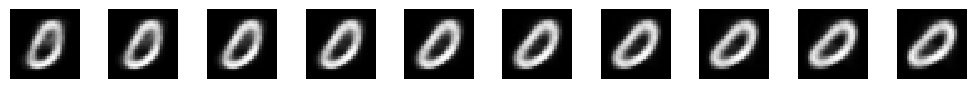

In [53]:
with torch.no_grad():
    alphas = torch.linspace(0, 1, 10)
    interpolated_latents = torch.stack([(1 - alpha) * z1 + alpha * z2 for alpha in alphas])
    generated = vae.decoder(interpolated_latents)
    plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28), dim=(1,10), figsize=(10,1))

## Bonus 2: Visualization
Generate a 10x10 mosaic by sampling *z* over a regulargrid in [-1,1]x[-1,1]. What do you observe?


(100, 1, 28, 28)


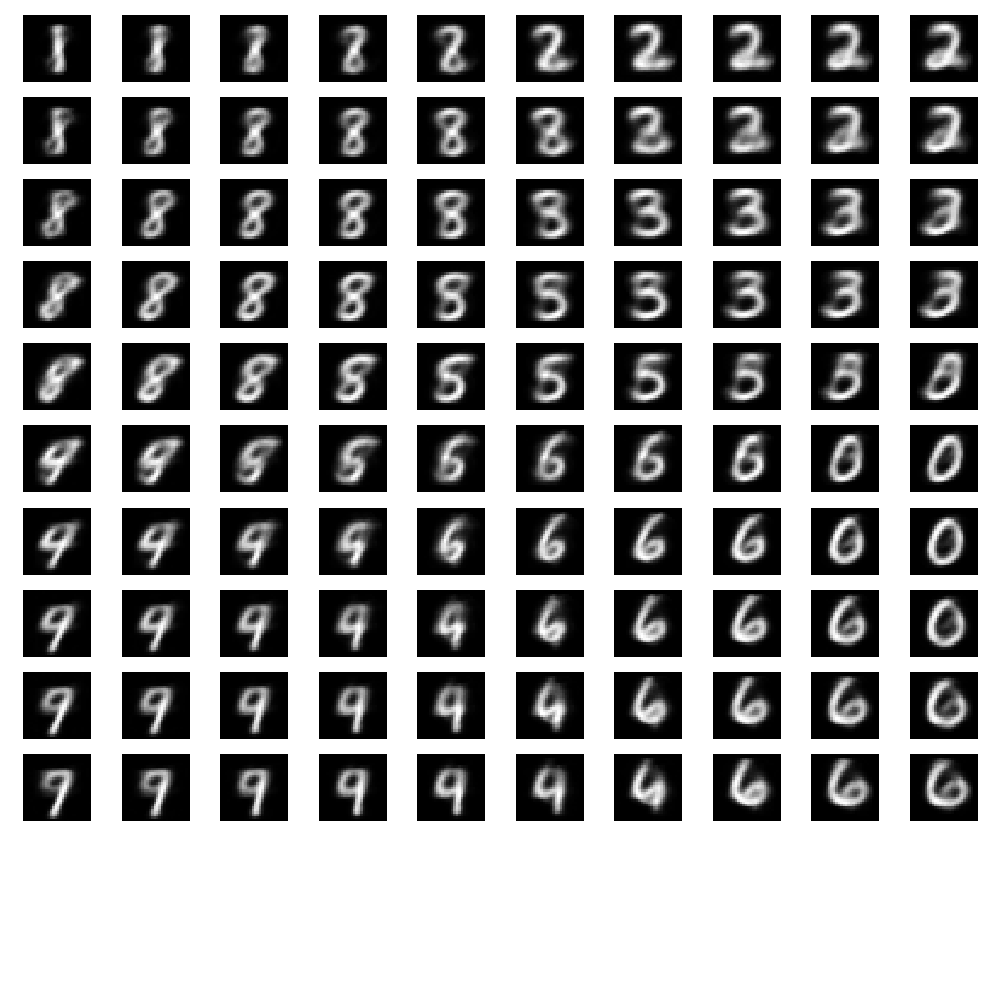

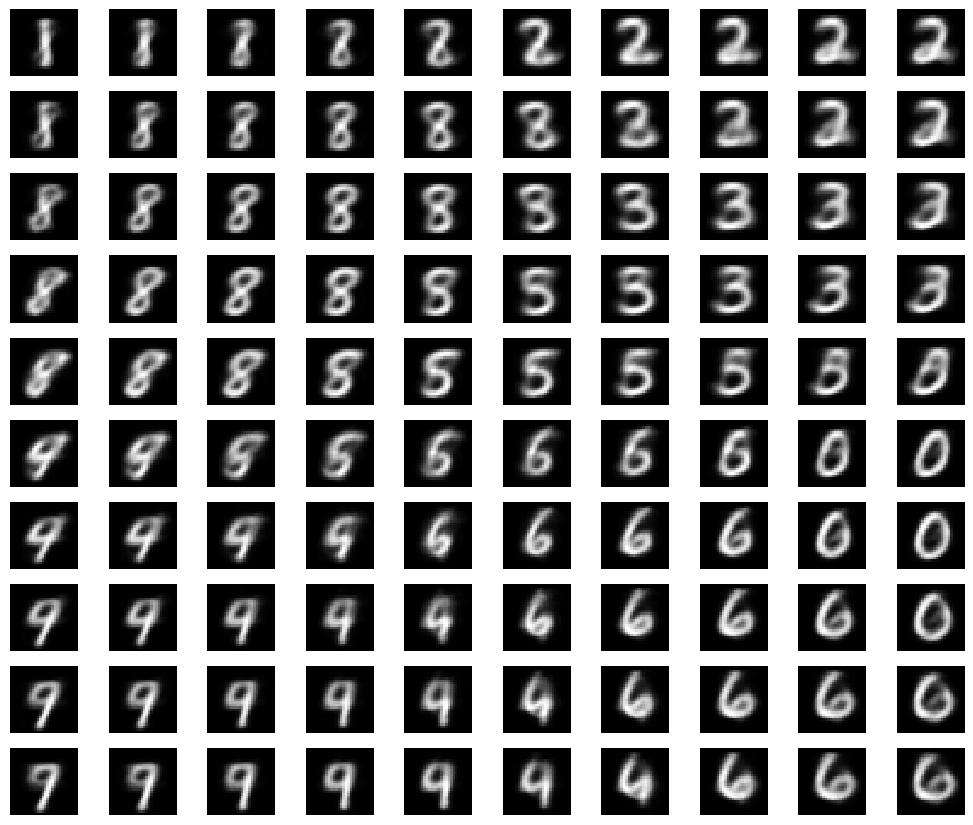

In [54]:
# ...
with torch.no_grad():
    # Create a regular grid of points in the range [-1, 1] x [-1, 1]
    x = torch.linspace(-1, 1, 10)
    y = torch.linspace(-1, 1, 10)
    grid_x, grid_y = torch.meshgrid(x, y)

    # Reshape the grid into a single tensor
    grid_z = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).cuda()

    # Generate images from the grid of latent vectors
    generated = vae.decoder(grid_z)
    plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28), dim = (12,10))



We can see that between 2 continuous frames, the image of the number changes slightly from one value to another.